<a href="https://colab.research.google.com/github/LokeshDandumahanti/Image_Captioning/blob/main/ImageCaptioning(Version5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importing Modules


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

#2. Importing Data

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

#3. Assigning Hyperparameters

In [ ]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

#4. Mapping processed captions to images through nlp


In [ ]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data




#5. Splitting train test data

In [ ]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


#6. Custom standardisation through basic nlp (Vectorization)

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


**Lowercase Conversion**: It converts the input string to lowercase using tf.strings.lower.

**Character Stripping**: It removes certain characters from the string using a regular expression. The characters to be removed are defined in the strip_chars variable.

In [ ]:
strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

**strip_chars** is a string containing various punctuation and special characters.
The replace methods remove the < and > characters from this string, so they will not be stripped out in the custom standardization process.

In [ ]:
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)


**TextVectorization**: This layer transforms a batch of strings (input text data) into a batch of token indices (integer values).

**max_tokens=VOCAB_SIZE**: Limits the number of unique tokens (words) to VOCAB_SIZE.

**output_mode="int"**: Outputs integer token indices.

**output_sequence_length**=SEQ_LENGTH: Pads or truncates sequences to a fixed length of SEQ_LENGTH.

**standardize=custom_standardization**: Applies the custom_standardization function to each input string before tokenization.

**vectorization.adapt(text_data)**: Fits the vectorization layer to the text_data, creating a vocabulary based on the text.

In [ ]:
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

**Lowercase Conversion**: It converts the input string to lowercase using tf.strings.lower.

**Character Stripping**: It removes certain characters from the string using a regular expression. The characters to be removed are defined in the strip_chars variable.




#7. Decoding, Resizing and making dataset (Dataset Preperation Pipeline)

---





In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

**decode_and_resize(img_path)**: This function takes the path of an image as input and performs several steps to decode and resize the image.

**tf.io.read_file(img_path)**: Reads the image file from the given path.

**tf.image.decode_jpeg(img, channels=3)**: Decodes the JPEG image to a tensor, ensuring it has 3 color channels (RGB).

**tf.image.resize(img, IMAGE_SIZE)**: Resizes the image to the specified IMAGE_SIZE.

**tf.image.convert_image_dtype(img, tf.float32)**: Converts the image to float32 type and normalizes pixel values to the range [0, 1].

In [ ]:
def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

**process_input(img_path, captions)**: This function processes an image and its corresponding captions.

**decode_and_resize(img_path)**: Resizes and normalizes the image as described above.

**vectorization(captions)**: Applies the previously defined text vectorization process to the captions, converting them into integer token indices.

Returns a tuple of the processed image tensor and the vectorized captions.

In [ ]:
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset

**make_dataset(images, captions)**: This function creates a tf.data.Dataset object from lists of image paths and captions.

**tf.data.Dataset.from_tensor_slices((images, captions))**: Creates a dataset from the image paths and captions, with each element being a tuple (image path, caption).

**dataset.shuffle(BATCH_SIZE * 8)** : Shuffles the dataset with a buffer size of BATCH_SIZE * 8 to ensure randomness.

**dataset.map(process_input,num_parallel_calls=AUTOTUNE)**: Maps the process_input function to each element of the dataset. AUTOTUNE optimizes the number of parallel calls.

**dataset.batch(BATCH_SIZE)**: Groups elements into batches of size BATCH_SIZE.

**dataset.prefetch(AUTOTUNE)**: Prefetches data to improve performance by overlapping data preprocessing and model training.

Returns the prepared dataset.

In [ ]:
# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

**train_dataset and valid_dataset**: These lines create the training and validation datasets.

**list(train_data.keys())**: Retrieves the list of image paths for the training data.

**list(train_data.values())**: Retrieves the list of captions for the training data.

**make_dataset(...)**: Creates a dataset from the image paths and captions for training and validation.

#8. Encoding, Attention and Decoding (CNN, Transformer, RNN)


In [ ]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

**get_cnn_model function:** This function creates a CNN model using EfficientNetB0.
efficientnet.EfficientNetB0: Loads the EfficientNetB0 model.

**input_shape=(*IMAGE_SIZE, 3)** :Sets the input shape based on IMAGE_SIZE and 3 color channels.

**include_top=False**: Excludes the fully connected layer at the top of the network.

**weights="imagenet"**: Initializes the model with pre-trained weights on the ImageNet dataset.

**base_model.trainable = False**: Freezes the base model layers to prevent them from being updated during training.

**base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)**: Reshapes the output to fit the desired shape.

**cnn_model = keras.models.Model(base_model.input, base_model_out)**: Creates the final CNN model using the input and reshaped output of the base model.

**return cnn_model:** Returns the created CNN model.

In [ ]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


**TransformerEncoderBlock class:** This class defines a transformer encoder block.

__init__: Initializes the block with specified parameters.

**embed_dim, dense_dim, num_heads**: Dimensions and number of attention heads.
layers.MultiHeadAttention: Multi-head attention layer.

**layers.LayerNormalization:** Layer normalization layers.

**layers.Dense:** Dense layer with ReLU activation.

**call**:

Defines the forward pass.

Normalizes and applies a dense layer to the inputs.

Applies multi-head attention to the inputs.

Normalizes and outputs the combined result of inputs and attention output.

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


**PositionalEmbedding:** This class defines positional embeddings for the input tokens.

**self.token_embeddings:** Embedding layer for the input tokens.

**self.position_embeddings:** Embedding layer for the positions of the tokens in the sequence.

**call(self, inputs):** This method defines the forward pass of the positional embedding layer.

Computes token embeddings and position embeddings.

Scales the token embeddings and adds them to the position embeddings.

**compute_mask(self, inputs, mask=None):** Computes a mask to indicate which tokens are padding tokens.

In [ ]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)

**TransformerDecoderBlock**: This class defines a single decoder block for a Transformer model.

**self.attention_1 and self.attention_2:** Multi-head attention layers.

**self.ffn_layer_1 and self.ffn_layer_2:** Feed-forward neural network layers.

**self.layernorm_1, self.layernorm_2, and self.layernorm_3:** Layer normalization layers.

**self.embedding:** Positional embedding layer for the input tokens.

**self.out**: Dense layer with softmax activation for output predictions.

**self.dropout_1 and self.dropout_2:** Dropout layers for regularization.

**call(self, inputs, encoder_outputs, training, mask=None)**: This method defines the forward pass of the decoder block.

Applies positional embedding to inputs.

Computes a causal attention mask.

Applies multi-head attention and adds it to the inputs, followed by layer normalization.

Applies multi-head attention with encoder outputs and adds it to the previous output, followed by layer normalization.

Passes the result through feed-forward layers and dropout layers, followed by layer normalization.

Computes the final predictions using a dense layer with softmax activation.

**get_causal_attention_mask(self, inputs)**: Computes a causal attention mask to prevent the model from attending to future tokens.

#9. Image Captioning Model

In [ ]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


__init__ **method**:

**Parameters**:

cnn_model: The CNN model used to extract image embeddings.

encoder: The encoder part of the model.

decoder: The decoder part of the model.

num_captions_per_image: Number of captions to generate per image (default is 5).

image_aug: Optional image augmentation function.

**Attributes**

Initializes the above parameters as attributes of the class.

Sets up loss and accuracy trackers.

**calculate_loss method:**

Parameters:

y_true: The true captions.

y_pred: The predicted captions.

mask: Mask to ignore padding.

**Functionality:**

Calculates the loss by applying the mask to ignore padding tokens.
Computes the masked average loss.

**calculate_accuracy method:**

Parameters:

y_true: The true captions.

y_pred: The predicted captions.
mask: Mask to ignore padding.

**Functionality:**

Calculates the accuracy by comparing the true and predicted captions, applying the mask to ignore padding tokens.

Computes the masked average accuracy

**_compute_caption_loss_and_acc method:**

Parameters:

img_embed: Image embeddings.

batch_seq: Sequence of captions for the batch.

training: Boolean indicating whether in training mode.

**Functionality:**

Processes image embeddings through the encoder.

Generates predictions using the decoder.
Computes loss and accuracy for the generated captions.

**train_step method:**

Parameters:

batch_data: A tuple of (batch_img, batch_seq) representing images and their corresponding captions.

**Functionality:**

Applies image augmentation if provided.
Extracts image embeddings using the CNN model.

Iterates through the captions, computing loss and accuracy for each.

Applies gradients to update the model's weights.

Updates loss and accuracy trackers.
Returns the current loss and accuracy.

**test_step method:**

Parameters:

batch_data: A tuple of (batch_img, batch_seq) representing images and their corresponding captions.

**Functionality:**

Extracts image embeddings using the CNN model.

Iterates through the captions, computing loss and accuracy for each (without updating weights).

Updates loss and accuracy trackers.
Returns the current loss and accuracy.

**calculate_accuracy method:**

Parameters:

y_true: The true captions.

y_pred: The predicted captions.
mask: Mask to ignore padding.

**Functionality:**

Calculates the accuracy by comparing the true and predicted captions, applying the mask to ignore padding tokens.

Computes the masked average accuracy.

**_compute_caption_loss_and_acc method:**

Parameters:

img_embed: Image embeddings.

batch_seq: Sequence of captions for the batch.

training: Boolean indicating whether in training mode.

**Functionality:**

Processes image embeddings through the encoder.

Generates predictions using the decoder.
Computes loss and accuracy for the generated captions.

**train_step method:**

Parameters:

batch_data: A tuple of (batch_img, batch_seq) representing images and their corresponding captions.

**Functionality:**

Applies image augmentation if provided.

Extracts image embeddings using the CNN model.

Iterates through the captions, computing loss and accuracy for each.

Applies gradients to update the model's weights.

Updates loss and accuracy trackers.

Returns the current loss and accuracy.

**test_step method:**

**Parameters:**

**batch_data:** A tuple of (batch_img, batch_seq) representing images and their corresponding captions.

**Functionality**:

Extracts image embeddings using the CNN model.

Iterates through the captions, computing loss and accuracy for each (without updating weights).

Updates loss and accuracy trackers.
Returns the current loss and accuracy.

**metrics** **property**:

**Functionality**:

Returns the list of metrics (loss and accuracy trackers) for automatic state reset.

**Model** **Initialization**:

**Components**:

cnn_model: CNN model to extract image features.

encoder: Transformer encoder block to process image embeddings.

decoder: Transformer decoder block to generate captions.

image_aug: Optional image augmentation function.

**Initialization**:

Instantiates the ImageCaptioningModel with the above components.

#10. Model Training

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='none',
)

**Functionality**:

Defines the loss function used for training the model.

**SparseCategoricalCrossentropy** is used because the problem is a multi-class classification where each class is represented as an integer (sparse format).

**from_logits**=False means that the predicted outputs are probabilities (not raw logits).

**reduction**=None means that no reduction is applied to the loss across the batch; individual losses for each element will be returned. This is useful when custom reduction is needed later, such as applying a mask.

In [ ]:
# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


**Functionality**:

Implements early stopping to prevent overfitting.

patience=3 means the training will stop if the validation loss does not improve for 3 consecutive epochs.

restore_best_weights=True means that after stopping, the model will revert to the weights from the epoch with the best validation loss.

In [ ]:
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


**Functionality**:

Defines a custom learning rate schedule.

**Parameters**:

**post_warmup_learning_rate**: The learning rate after the warmup phase.

**warmup_steps**: The number of steps for the warmup phase.

**Method**:

During the warmup phase, the learning rate increases linearly from 0 to post_warmup_learning_rate.

After the warmup phase, the learning rate is constant at post_warmup_learning_rate.

The learning rate is computed based on the current training step.

In [ ]:
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

**Functionality**:

Calculates the total number of training steps as the product of the number of training samples and the number of epochs.

Sets the number of warmup steps to be 1/15th of the total training steps.

Creates an instance of the LRSchedule class with a post-warmup learning rate of 1e-4 and the calculated number of warmup steps.

In [ ]:
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)


**Functionality**:

Compiles the image captioning model.
Uses the Adam optimizer with the custom learning rate schedule.

Sets the loss function to the previously defined sparse categorical cross-entropy.

In [ ]:
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
18/96 ━━━━━━━━━━━━━━━━━━━━ 1:09 886ms/step - acc: 0.0271 - loss: 45.1788

KeyboardInterrupt: 

**Functionality**:

Trains the model on the training dataset for a specified number of epochs (EPOCHS).

Uses the validation dataset to evaluate the model's performance after each epoch.

Applies the early stopping callback to stop training if the validation loss does not improve for 3 consecutive epochs and restore the best weights.

#11. Sample Prediction


**1.Select a Random Image:**

Selects a random image from the validation dataset using np.random.choice(valid_images).

**Read and Display the Image:**

Reads the image from disk and resizes it using decode_and_resize().

Converts the image tensor to a NumPy array, clips the pixel values to the range [0, 255], and casts it to np.uint8 for displaying.

Displays the image using plt.imshow() and plt.show().

**Pass the Image to the CNN:**

Expands the dimensions of the image tensor to match the expected input shape of the CNN model.

Passes the image through the CNN model to extract features.

**Pass the Image Features to the Encoder:**

Passes the extracted image features through the encoder part of the model.

**Generate the Caption:**

Initializes the decoded caption with the start token "<start> ".

Iteratively generates the caption token by token:

Tokenizes the current caption using vectorization.
  
Creates a mask to ignore padding tokens.

Passes the tokenized caption and encoded image features to the decoder to get predictions.

Selects the token with the highest probability (np.argmax(predictions[0, i, :])).

Converts the token index to the corresponding word using index_lookup.

Adds the sampled token to the caption and breaks the loop if the end token "<end>" is generated.

Removes the start and end tokens from the generated caption and prints it.

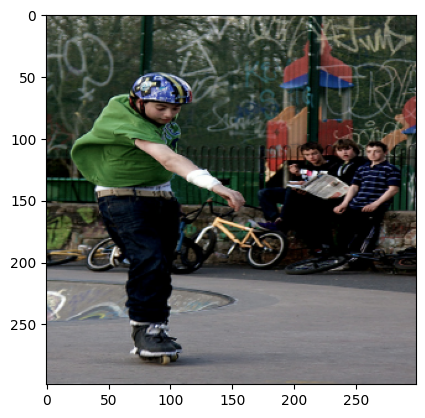

KeyError: 8922

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()